In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

##############################
######### DEFINITIONS ########
##############################

# ============================
#  1) Data reading
# ============================
cylinder = np.loadtxt('cylinder.txt')
FFA_W3_301 = np.loadtxt('FFA-W3-301.txt')
FFA_W3_360 = np.loadtxt('FFA-W3-360.txt')
FFA_W3_480 = np.loadtxt('FFA-W3-480.txt')
FFA_W3_600 = np.loadtxt('FFA-W3-600.txt')
FFA_W3_241 = np.loadtxt('FFA-W3-241.txt')   # fixed filename
blade_data = np.loadtxt('bladedat.txt')

number_of_airfoils = 6
thickness_to_chord = np.array([100, 60, 48, 36, 30.1, 24.1])

# Concatenate airfoils horizontally for easy indexing (we stack all airfoil data into one matrix)
total_data_airfoils = np.hstack([
    cylinder, FFA_W3_600, FFA_W3_480,
    FFA_W3_360, FFA_W3_301, FFA_W3_241
])

# Extract AoA/Cl/Cd tables per airfoil
aoa = np.zeros((total_data_airfoils.shape[0], number_of_airfoils)) # Angle of Attack
lift_coefficient = np.zeros_like(aoa)
drag_coefficients = np.zeros_like(aoa)

pos = 0
for k in range(number_of_airfoils):
    aoa[:, k] = total_data_airfoils[:, pos]
    lift_coefficient[:, k] = total_data_airfoils[:, pos + 1]
    drag_coefficients[:, k] = total_data_airfoils[:, pos + 2]
    pos += 4

# Blade radial stations
radius = blade_data[:, 0]

# ============================
#  2) Turbine parameters
# ============================
R = 89.17   # [m]
Blades = 3  # [-]
P_rated = 10    # [MW]
V_in = 4    # [m/s]
V_out = 25  # [m/s]
rho = 1.225 # [kg/m^3]

tip_pitch = np.arange(-3, 4.5, 0.5)       # [deg]
tip_speed_ratio = np.arange(5, 10.5, 0.5) # [-]

V0 = 8  # Operating wind speed [m/s]

# =====================================================================
#  3) Function definitions (all equations we will use)
# =====================================================================

def flow_angle(V0, a, ap, Omega, r):
    """
    Flow angle φ from the velocity triangle:
        tan φ = ( (1 - a) V0 ) / ( (1 + a') Ω r )
    """
    return np.arctan(((1 - a) * V0) / ((1 + ap) * Omega * r))


def angle_of_attack(phi, twist, theta_p):
    """
    Angle of attack α in degrees:
        α = φ - (twist + θ_p)
    where twist and θ_p are in radians.
    """
    return np.rad2deg(phi - (twist + theta_p))


def interpolate_airfoil(alpha_deg, t_over_c,
                        aoa_table, cl_table, cd_table,
                        thickness_vec):
    """
    Double interpolation of Cl(α, t/c) and Cd(α, t/c).

    1) For each of the 6 airfoils, interpolate Cl and Cd at angle α.
    2) With those 6 values, interpolate in thickness ratio t/c
       corresponding to the blade section.
    """
    clthick = []  # Empty list to store, for each airfoil k, the value of Cl at angle of attack alpha_deg.
    cdthick = []  # Empty list to store, for each airfoil k, the value of Cd at angle of attack alpha_deg.

    for k in range(cl_table.shape[1]):                             # cl_table.shape[1] = number of columns of cl_table (6 in this case)
        f_cl = interp1d(aoa_table[:, k], cl_table[:, k],           # Here we have all angles of attack and we interpolate to get Cl values between them
                        kind='linear', fill_value="extrapolate")
        f_cd = interp1d(aoa_table[:, k], cd_table[:, k],
                        kind='linear', fill_value="extrapolate")
        clthick.append(f_cl(alpha_deg))
        cdthick.append(f_cd(alpha_deg))

    Cl = interp1d(thickness_vec, clthick,
                  kind='linear', fill_value="extrapolate")(t_over_c)
    Cd = interp1d(thickness_vec, cdthick,
                  kind='linear', fill_value="extrapolate")(t_over_c)
    return Cl, Cd


def force_coefficients(Cl, Cd, phi):
    """
    Normal and tangential coefficients with respect to the rotor plane:
        Cn = Cl cosφ + Cd sinφ
        Ct = Cl sinφ - Cd cosφ
    """
    Cn = Cl * np.cos(phi) + Cd * np.sin(phi)
    Ct = Cl * np.sin(phi) - Cd * np.cos(phi)
    return Cn, Ct


def solidity(B, chord, r):
    """
    Local solidity:
        σ = B c / (2 π r)
    """
    return B * chord / (2 * np.pi * r)


def prandtl_tip_loss(B, R, r, phi):
    """
    Prandtl's tip loss factor:
        F = 2/π * arccos( exp( -B(R-r) / (2 r |sinφ|) ) )
    (Clipped to [1e-6, 1] to avoid division by zero)
    """
    ftip = (B * (R - r)) / (2 * r * abs(np.sin(phi)))
    F = (2 / np.pi) * np.arccos(np.exp(-max(0.0, ftip)))
    return np.clip(F, 1e-6, 1.0)


def local_CT_from_Cn_sigma(a, Cn, sigma, phi):
    """
    Local thrust coefficient C_T from BEM (blade element expression):
        C_T = ((1 - a)^2 * Cn * σ) / sin^2 φ
    """
    return ((1 - a) ** 2 * Cn * sigma) / (np.sin(phi) ** 2)



# ---------------------------------------------------------------------
#  Eq. (2) of Madsen: a(C_T) polynomic function
# ---------------------------------------------------------------------
def a_Madsen_from_CT(CT_over_F):
    """
    Eq. (2) – Madsen et al. correlation for a(C_T).
        a = 0.246 * C_T* + 0.0586 * (C_T*)^2 + 0.0883 * (C_T*)^3
    where C_T* = C_T / F (C_T corrected with the tip-loss).
    """
    x = np.asarray(CT_over_F, dtype=float)
    return 0.246 * x + 0.0586 * x**2 + 0.0883 * x**3


def update_a_ap(a_old, ap_old, Cn, Ct, sigma, phi, F,
                f_relax=0.10, use_madsen=False):
    """
    Update induction factors a and a' using:
      - BEM equation for thrust (Cn, σ, φ, F) to obtain local C_T.
      - Glauert (Eq. 1) or Madsen (Eq. 2) to relate a and C_T.
      - Under-relaxation: a_new = a_old + f (a_star - a_old).
    """

    # --- a) Local thrust coefficient from blade element
    CT_local = local_CT_from_Cn_sigma(a_old, Cn, sigma, phi)

    # --- b) Axial induction factor a
    if not use_madsen:
        # Classical Glauert model:
        if a_old <= 0.33:
            # From momentum theory C_T = 4 F a (1 - a)  ⇒  a solved as:
            a_star = (sigma * Cn * (1 - a_old)) / (4 * F * np.sin(phi)**2)
        else:
            # Glauert high-induction correction:
            # dC_T is the local C_T based on Cn, σ, φ
            dCT = CT_local
            # Denominator corresponds to C_T(a) of Glauert (Eq. 1)
            denom = 4 * F * (1 - 0.25 * (5 - 3 * a_old) * a_old)
            a_star = dCT / denom
    else:
        # Madsen model: first normalize with F and then
        # use a = f(C_T/F) (Eq. 2).
        CT_corr = CT_local / F
        a_star = a_Madsen_from_CT(CT_corr)

    # Under-relaxation for a
    a_new = a_old + f_relax * (a_star - a_old)

    # --- c) Tangential induction factor a'
    # BEM (angular momentum) equation for a':
    #   a'_star = (σ Ct (1 + a')) / (4 F sinφ cosφ)
    # (the old value a' is used on RHS and iterated).
    ap_star = (sigma * Ct * (1 + ap_old)) / (4 * F * np.sin(phi) * np.cos(phi))
    ap_new = ap_old + f_relax * (ap_star - ap_old)

    return a_new, ap_new


def relative_velocity(V0, a, ap, Omega, r):
    """
    Magnitude of the relative velocity at the section:
        V_rel^2 = ((1 - a) V0)^2 + ((1 + a') Ω r)^2
    """
    return np.sqrt(((1 - a) * V0) ** 2 + ((1 + ap) * Omega * r) ** 2)


def section_loads(rho, Vrel, chord, Cl, Cd, phi):
    """
    Aerodynamic loads per unit length at the section:
        L = 1/2 ρ V_rel^2 c Cl
        D = 1/2 ρ V_rel^2 c Cd

    Projected into tangential (Pt) and normal (Pn) directions:
        Pt = L sinφ - D cosφ
        Pn = L cosφ + D sinφ
    """
    L = 0.5 * rho * Vrel**2 * chord * Cl
    D = 0.5 * rho * Vrel**2 * chord * Cd

    Pt = L * np.sin(phi) - D * np.cos(phi)
    Pn = L * np.cos(phi) + D * np.sin(phi)
    return Pt, Pn


def _idx_near(arr, val):
    """Index of the value in arr closest to val."""
    return int(np.argmin(np.abs(np.asarray(arr) - val)))

def torque (Blades, radius, Pt_elem):
    """ Integral M = B ∫ r * Pt(r) dr [N·m]
    """
    return Blades * np.trapezoid(radius * Pt_elem, radius)

def thrust (Blades, radius, Pn_elem):
    """ Integral T = B ∫ Fn(r) dr [N]
    """
    return Blades * np.trapezoid(Pn_elem, radius)

def compute_cp (Torque, Omega, rho, R, V0):
    """ Power coefficient
        Cp = Power generated by the turbine / Power available in the wind
        P_turbine = Cp * P_wind = Cp * 0.5 * rho * A * V0**3
    """
    A = np.pi * R ** 2
    P = Torque * Omega
    return P / (0.5 * rho * A * V0**3)

def compute_ct (Thrust, rho, A, V0):
    """ Thrust coefficient
        C_T = T / (0.5 rho A V0^2)
    """
    return Thrust / (0.5 * rho * A * V0**2)




Maximum power coefficient
Cp_max = 0.4662
  -> at lambda       = 8.000
  -> at pitch theta_p = 0.000 deg


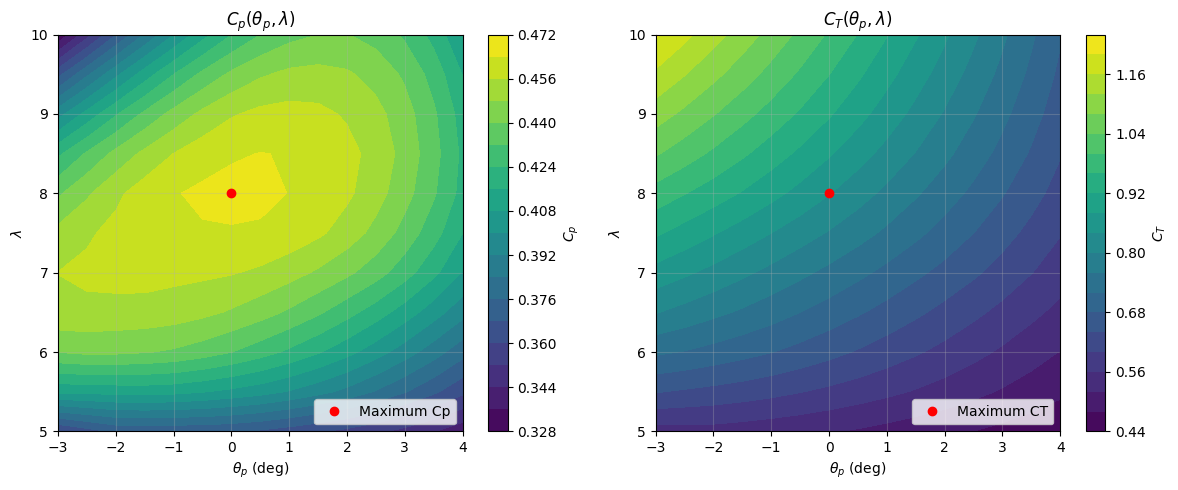

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

##################################
##### BEM COMPLETE RADIUS ########
##################################

# =====================================================
# Chuleta tipos de datos
#   float: número "en coma flotante", simplemente significa q tiene parte decimal Ej.: 3.0 y 2.865 son floats
#   int: número entero
#   1D Array: Vector
#   2D Array: matriz/tabla

# =====================================================

#


def compute_complete_BEM(tip_speed_ratio,
                         tip_pitch,
                         V0,
                         R,
                         Blades,
                         blade_data,
                         radius,
                         aoa,
                         lift_coefficient,
                         drag_coefficients,
                         thickness_to_chord,
                         rho):
    """
    Run the full BEM sweep over tip_speed_ratio and tip_pitch,
    compute Cp and CT maps, and find optimal operating points.

    Parameters
    ----------
    tip_speed_ratio : 1D Array, lambda values (ΩR / V0) to sweep.
    tip_pitch : 1D Array, pitch angles at the tip [deg] to sweep.
    V0 : float  Free-stream wind speed [m/s].
    R : float, Rotor radius [m].
    Blades : int, Number of blades.
    blade_data : 2D array, Blade geometry: [r, chord, twist(deg), t_over_c, ...].
    radius : 1D array, Radial positions of blade sections [m].
    aoa, lift_coefficient, drag_coefficients : 2D arrays. Airfoil polars vs AoA and airfoil index.
    thickness_to_chord : 1D array, Thickness ratios (t/c) corresponding to each airfoil.
    rho : float, Air density [kg/m^3].

    Returns
    -------
    cp : 2D array. Power coefficient map Cp(lambda, theta_p).
    c_thrust : 2D array. Thrust coefficient map CT(lambda, theta_p).
    thrust_abs : 2D array. Absolute thrust [N] for each (lambda, theta_p).
    cp_max : float. Maximum Cp over the sweep.
    lambda_opt : float. Lambda at which Cp is maximum.
    theta_opt : float. Pitch angle (deg) at which Cp is maximum.
    ct_max : float. Maximum CT over the sweep.
    lambda_ct : float. Lambda at which CT is maximum.
    theta_ct : float. Pitch angle (deg) at which CT is maximum.
    """

    # ============================
    #  4) Matrix initialization
    # ============================
    cp = np.zeros((len(tip_speed_ratio), len(tip_pitch)))
    c_thrust = np.zeros_like(cp)
    thrust_abs = np.zeros_like(cp)

    A = np.pi * R ** 2  # rotor swept area

    # =======================================================
    #  5) Main loop over λ and θp using the functions
    # =======================================================
    # Here we perform a double sweep to compute Cp as a function of λ and θp

    for ii, lam in enumerate(tip_speed_ratio):
        Omega = lam * V0 / R
        #lam = Omega*R/V0

        for jj, theta in enumerate(tip_pitch):
            theta_p = np.deg2rad(theta)

            Pt_elem = np.zeros(blade_data.shape[0])
            Pn_elem = np.zeros(blade_data.shape[0])

            for e in range(blade_data.shape[0] - 1):
                r = radius[e]
                chord = blade_data[e, 1]
                twist = np.deg2rad(blade_data[e, 2])
                t_over_c = blade_data[e, 3]

                # Initial values for a and a'
                a, a_new = 0.35, 0.10
                ap, ap_new = 0.0, 0.10
                f_relax = 0.10
                tol_res = 1e-6
                it, itmax = 0, 1000

                # ------------------------------
                #  BEM iteration at this element
                # ------------------------------
                while True:
                    it += 1
                    a, ap = a_new, ap_new

                    # Velocity triangle
                    phi = flow_angle(V0, a, ap, Omega, r)
                    alpha_deg = angle_of_attack(phi, twist, theta_p)

                    # Cl(α, t/c) and Cd(α, t/c)
                    Cl, Cd = interpolate_airfoil(
                        alpha_deg, t_over_c,
                        aoa, lift_coefficient, drag_coefficients,
                        thickness_to_chord
                    )

                    # Cn and Ct coefficients
                    Cn, Ct = force_coefficients(Cl, Cd, phi)

                    # Solidity and tip-loss factor
                    sigma = solidity(Blades, chord, r)
                    F = prandtl_tip_loss(Blades, R, r, phi)

                    # Update a and a' (by default using Glauert Eq.1;
                    # set use_madsen=True if you want to use Madsen Eq.2)
                    a_new, ap_new = update_a_ap(
                        a, ap, Cn, Ct, sigma, phi, F,
                        f_relax=f_relax,
                        use_madsen=False
                    )

                    # Residuals for stopping the iteration
                    res_n = a_new - a
                    res_t = ap_new - ap

                    if max(abs(res_n), abs(res_t)) < tol_res or it >= itmax:
                        a, ap = a_new, ap_new
                        break

                # ------------------------------
                #  Loads with converged a and a'
                # ------------------------------
                phi = flow_angle(V0, a, ap, Omega, r)
                alpha_deg = angle_of_attack(phi, twist, theta_p)

                Cl, Cd = interpolate_airfoil(
                    alpha_deg, t_over_c,
                    aoa, lift_coefficient, drag_coefficients,
                    thickness_to_chord
                )

                Vrel = relative_velocity(V0, a, ap, Omega, r)
                Pt_elem[e], Pn_elem[e] = section_loads(
                    rho, Vrel, chord, Cl, Cd, phi
                )

            # Integration along the radius
            Torque = torque(Blades, radius, Pt_elem)
            Thrust = thrust(Blades, radius, Pn_elem)

            # Cp and C_T using the helper functions
            cp[ii, jj] = compute_cp(Torque, Omega, rho, R, V0)
            c_thrust[ii, jj] = compute_ct(Thrust, rho, A, V0)
            thrust_abs[ii, jj] = Thrust

    # ============ 6) Post-processing (numerical only, no plots) ============

    cp_max = np.max(cp)
    row, col = np.unravel_index(np.argmax(cp), cp.shape)
    lambda_opt = tip_speed_ratio[row]
    theta_opt = tip_pitch[col]

    ct_max = np.max(c_thrust)
    row_ct, col_ct = np.unravel_index(np.argmax(c_thrust), c_thrust.shape)
    lambda_ct = tip_speed_ratio[row_ct]
    theta_ct = tip_pitch[col_ct]

    return cp, c_thrust, thrust_abs, cp_max, lambda_opt, theta_opt, ct_max, lambda_ct, theta_ct


# Run full BEM
cp, c_thrust, thrust_abs, cp_max, lambda_opt, theta_opt, ct_max, lambda_ct, theta_ct = compute_complete_BEM(
    tip_speed_ratio,
    tip_pitch,
    V0,
    R,
    Blades,
    blade_data,
    radius,
    aoa,
    lift_coefficient,
    drag_coefficients,
    thickness_to_chord,
    rho
)




Maximum power coefficient
Cp_max = 0.4662
  -> at lambda       = 8.000
  -> at pitch theta_p = 0.000 deg
  -> corresponding C_T = 0.8420

Maximum thrust coefficient:
C_T_max = 1.2059
  -> at lambda       = 10.000
  -> at pitch theta_p = -3.000 deg


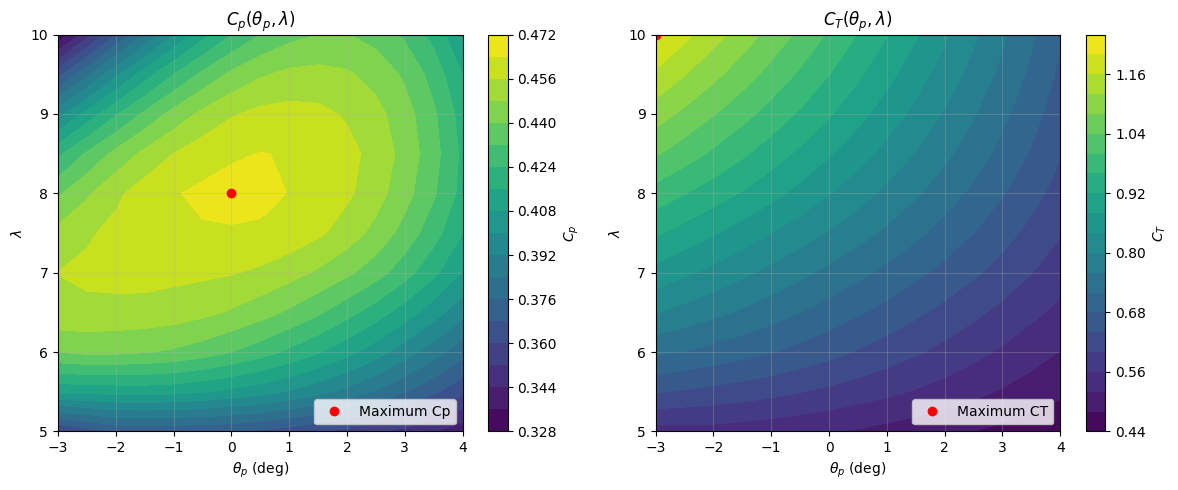


===== Rated operating point (from Cp_max) =====
V_rated  = 11.426 m/s
Omega_max = 1.0251 rad/s


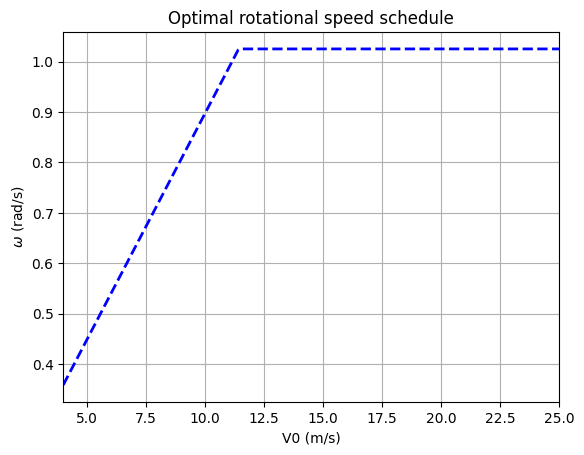

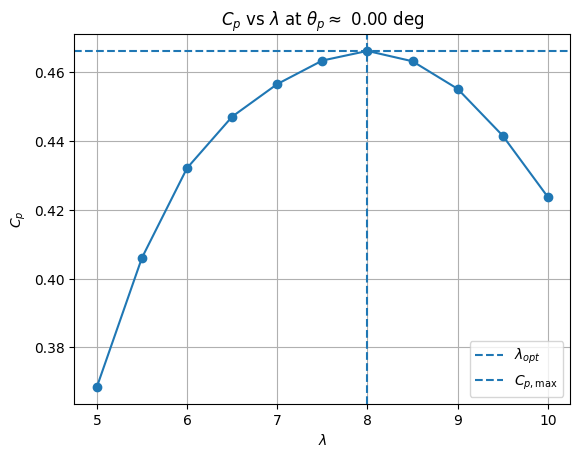

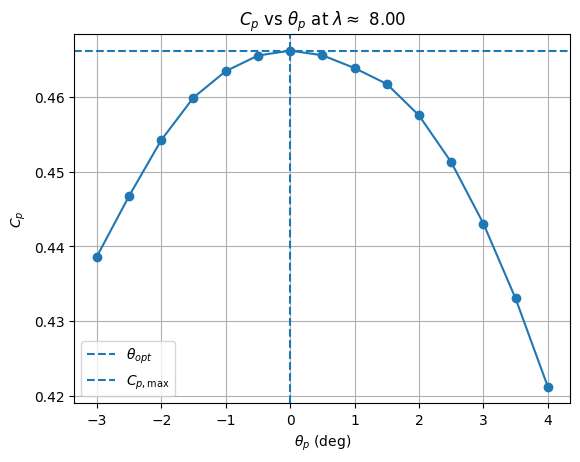

In [4]:
####################################
######## RESULTS AND PLOTS #########
####################################

# C_T correspondiente al Cp máximo:
# buscamos dónde está el Cp máximo (ya lo hemos usado en la función -> row, col)
# pero lo podemos recomputar aquí igual:
row_cp, col_cp = np.unravel_index(np.argmax(cp), cp.shape) 
c_thrust_at_cpmax = c_thrust[row_cp, col_cp]
# Argmax devuelve un número entero, es decir la posición 17 por ej., luego con cp.shape le decimos q nos lo devuelva con la forma de la matriz ej.: posición de la matriz (5,12)
# np.unravel_index(indice_plano, shape) → convierte ese índice plano en un par (fila, columna) adecuado para esa forma.
# Es decir: “Desenrolla” (un-ravel) el índice 1D en índices multidimensionales.

# ============================
#  Prints resumen
# ============================
print("\nMaximum power coefficient")
print(f"Cp_max = {cp_max:.4f}")
print(f"  -> at lambda       = {lambda_opt:.3f}")
print(f"  -> at pitch theta_p = {theta_opt:.3f} deg")
print(f"  -> corresponding C_T = {c_thrust_at_cpmax:.4f}")

print("\nMaximum thrust coefficient:")
print(f"C_T_max = {ct_max:.4f}")
print(f"  -> at lambda       = {lambda_ct:.3f}")
print(f"  -> at pitch theta_p = {theta_ct:.3f} deg")

X, Y = np.meshgrid(tip_pitch, tip_speed_ratio)

# ============================
#  Contours Cp and C_T
# ============================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Cp
cs1 = axs[0].contourf(tip_pitch, tip_speed_ratio, cp, levels=20, cmap="viridis")
fig.colorbar(cs1, ax=axs[0], label=r"$C_p$")
axs[0].plot(theta_opt, lambda_opt, "ro", ms=6, label="Maximum Cp")
axs[0].set_xlabel(r"$\theta_p$ (deg)")
axs[0].set_ylabel(r"$\lambda$")
axs[0].set_title(r"$C_p(\theta_p,\lambda)$")
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc="lower right")

# CT
cs2 = axs[1].contourf(tip_pitch, tip_speed_ratio, c_thrust, levels=20, cmap="viridis")
fig.colorbar(cs2, ax=axs[1], label=r"$C_T$")
axs[1].plot(theta_ct, lambda_ct, "ro", ms=6, label="Maximum CT")
axs[1].set_xlabel(r"$\theta_p$ (deg)")
axs[1].set_ylabel(r"$\lambda$")
axs[1].set_title(r"$C_T(\theta_p,\lambda)$")
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()



# ================================================
#  7) Rated wind & ω(V) curve (also outside function)
# ================================================
P_max_W = 10.64e6 # CAMBIAR SEGUN LO QUE PONGA EN DTU10MW O LO QUE SEA
if cp_max <= 0 or np.isnan(cp_max):
    raise ValueError(f"Invalid cp_max = {cp_max}. Check input data/interpolation.")

V_rated = (P_max_W / (0.5 * rho * np.pi * R ** 2 * cp_max)) ** (1 / 3)
Omega_max = lambda_opt * V_rated / R

print("\n===== Rated operating point (from Cp_max) =====")
print(f"V_rated  = {V_rated:.3f} m/s")
print(f"Omega_max = {Omega_max:.4f} rad/s")

V_vec = np.arange(V_in, V_out + 0.1, 0.1)
omega_vec = (lambda_opt * V_vec) / R
omega_vec[omega_vec > Omega_max] = Omega_max

plt.figure()
plt.plot(V_vec, omega_vec, 'b--', linewidth=2)
plt.xlabel('V0 (m/s)')
plt.ylabel(r'$\omega$ (rad/s)')
plt.grid(True)
plt.xlim([V_in, V_out])
plt.title('Optimal rotational speed schedule')
plt.show()

# ============================
#  Plots 1D adicionales
# ============================

# (Optional) Cp vs lambda at theta_p ≈ theta_opt
idx_theta_opt = _idx_near(tip_pitch, theta_opt)
plt.figure()
plt.plot(tip_speed_ratio, cp[:, idx_theta_opt], "o-")
plt.axvline(lambda_opt, linestyle="--", label=r"$\lambda_{opt}$")
plt.axhline(cp_max, linestyle="--", label=r"$C_{p,\max}$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$C_p$")
plt.title(r"$C_p$ vs $\lambda$ at $\theta_p \approx$ " + f"{tip_pitch[idx_theta_opt]:.2f} deg")
plt.grid(True)
plt.legend()
plt.show()

# (Optional) Cp vs theta_p at lambda ≈ lambda_opt
idx_lambda_opt = _idx_near(tip_speed_ratio, lambda_opt)
plt.figure()
plt.plot(tip_pitch, cp[idx_lambda_opt, :], "o-")
plt.axvline(theta_opt, linestyle="--", label=r"$\theta_{opt}$")
plt.axhline(cp_max, linestyle="--", label=r"$C_{p,\max}$")
plt.xlabel(r"$\theta_p$ (deg)")
plt.ylabel(r"$C_p$")
plt.title(r"$C_p$ vs $\theta_p$ at $\lambda \approx$ " + f"{tip_speed_ratio[idx_lambda_opt]:.2f}")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
#############################
##### BEM SINGLE RADIUS #####
#############################

def BEM_single_radius(Omega,
                      theta_deg,
                      V0,
                      R,
                      Blades,
                      r,
                      chord,
                      twist_deg,
                      t_over_c,
                      aoa,
                      lift_coefficient,
                      drag_coefficients,
                      thickness_to_chord,
                      rho,
                      f_relax=0.10,
                      tol_res=1e-6,
                      itmax=1000,
                      use_madsen=False):
    """
    Run BEM iteration for a single radial station (one r).

    Parameters
    ----------
    lam : float, Tip speed ratio λ = ΩR / V0 for this operating point.
    theta_deg : float, Pitch angle θ_p at the blade tip [deg] (here applied locally).
    V0 : float, Free-stream wind speed [m/s].
    R : float, Rotor radius [m].
    Blades : int, Number of blades.
    r : float, Radial position of this section [m].
    chord : float, Local chord length [m].
    twist_deg : float, Local twist angle [deg].
    t_over_c : float, Local relative thickness (t/c) of the airfoil.
    aoa, lift_coefficient, drag_coefficients : 2D arrays. Airfoil polars vs AoA and airfoil index.
    thickness_to_chord : 1D array, Thickness ratios (t/c) corresponding to each airfoil.
    rho : float, Air density [kg/m^3].
    f_relax : float, optional, Under-relaxation factor for a and a'.
    tol_res : float, optional, Convergence tolerance for a and a'.
    itmax : int, optional, Maximum number of iterations.
    use_madsen : bool, optional
        If True, use Madsen correlation for a(C_T);
        if False, use Glauert approach.

    Returns
    -------
    results : dict
        Dictionary with:
          'a'       : converged axial induction factor
          "a'"      : converged tangential induction factor
          'phi'     : flow angle [rad]
          'alpha'   : angle of attack [deg]
          'Cl'      : lift coefficient
          'Cd'      : drag coefficient
          'Cn'      : normal force coefficient
          'Ct'      : tangential force coefficient
          'Vrel'    : relative velocity magnitude [m/s]
          'Pt'      : tangential load per unit length [N/m]
          'Pn'      : normal load per unit length [N/m]
          'CT_local': local thrust coefficient from BEM
          'iterations': number of iterations used
    """

    # Angular speed from lambda
    # Omega = lam * V0 / R
    lam = Omega * R / V0

    # Convert angles to radians
    theta_p = np.deg2rad(theta_deg)
    twist = np.deg2rad(twist_deg)

    # Initial guesses for a and a'
    a, a_new = 0.35, 0.10
    ap, ap_new = 0.0, 0.10
    it = 0

    # ------------------------------
    #  BEM iteration at this radius
    # ------------------------------
    while True:
        it += 1
        a, ap = a_new, ap_new

        # Velocity triangle
        phi = flow_angle(V0, a, ap, Omega, r)
        alpha_deg = angle_of_attack(phi, twist, theta_p)

        # Cl(α, t/c) and Cd(α, t/c)
        Cl, Cd = interpolate_airfoil(
            alpha_deg, t_over_c,
            aoa, lift_coefficient, drag_coefficients,
            thickness_to_chord
        )

        # Cn and Ct coefficients
        Cn, Ct = force_coefficients(Cl, Cd, phi)

        # Solidity and tip-loss factor
        sigma = solidity(Blades, chord, r)
        F = prandtl_tip_loss(Blades, R, r, phi)

        # Update a and a'
        a_new, ap_new = update_a_ap(
            a, ap, Cn, Ct, sigma, phi, F,
            f_relax=f_relax,
            use_madsen=use_madsen
        )

        # Residuals for stopping the iteration
        res_n = a_new - a
        res_t = ap_new - ap

        if max(abs(res_n), abs(res_t)) < tol_res or it >= itmax:
            a, ap = a_new, ap_new
            break

    # ------------------------------
    #  Loads and coefficients with converged a and a'
    # ------------------------------
    phi = flow_angle(V0, a, ap, Omega, r)
    alpha_deg = angle_of_attack(phi, twist, theta_p)

    Cl, Cd = interpolate_airfoil(
        alpha_deg, t_over_c,
        aoa, lift_coefficient, drag_coefficients,
        thickness_to_chord
    )

    Cn, Ct = force_coefficients(Cl, Cd, phi)
    sigma = solidity(Blades, chord, r)
    CT_local = local_CT_from_Cn_sigma(a, Cn, sigma, phi)

    Vrel = relative_velocity(V0, a, ap, Omega, r)
    Pt, Pn = section_loads(rho, Vrel, chord, Cl, Cd, phi)

    results = {
        'a': a,
        "a'": ap,
        'phi': phi,
        'alpha': alpha_deg,
        'Cl': Cl,
        'Cd': Cd,
        'Cn': Cn,
        'Ct': Ct,
        'Vrel': Vrel,
        'Pt': Pt,
        'Pn': Pn,
        'CT_local': CT_local,
        'iterations': it
    }

    return results

# ================================================
#  Local BEM info at r/R ≈ 0.7 and (lambda_opt, theta_opt)
# ================================================

# Choose a radius close to r/R = 0.7
idx_07 = _idx_near(radius / R, 0.7)

r_sec        = radius[idx_07]
chord_sec    = blade_data[idx_07, 1]
twist_sec    = blade_data[idx_07, 2]   # [deg] in blade_data
t_over_c_sec = blade_data[idx_07, 3]

# Run single-radius BEM at the *global* optimum operating point
res_loc = BEM_single_radius(lambda_opt,
                            theta_opt,
                            V0,
                            R,
                            Blades,
                            r_sec,
                            chord_sec,
                            twist_sec,
                            t_over_c_sec,
                            aoa,
                            lift_coefficient,
                            drag_coefficients,
                            thickness_to_chord,
                            rho)

print("\n Local aerodynamics at Cp_max (r/R ≈ 0.7) ")
print(f"r/R           ≈ {r_sec / R:.3f}")
print(f"lambda_opt    = {lambda_opt:.3f}")
print(f"theta_opt     = {theta_opt:.3f} deg")
print(f"a (axial)     ≈ {res_loc['a']:.3f}")
print(f"a_tan (a')    ≈ {res_loc["a'"]:.3f}")
print(f"phi           ≈ {np.rad2deg(res_loc['phi']):.2f} deg")
print(f"alpha         ≈ {res_loc['alpha']:.2f} deg")
print(f"Cl            ≈ {res_loc['Cl']:.3f}")
print(f"Cd            ≈ {res_loc['Cd']:.4f}")
print(f"Cn            ≈ {res_loc['Cn']:.3f}")
print(f"Ct            ≈ {res_loc['Ct']:.3f}")
print(f"C_T,local     ≈ {res_loc['CT_local']:.3f}")
print(f"V_rel         ≈ {res_loc['Vrel']:.2f} m/s")
print(f"Pt (tang.)    ≈ {res_loc['Pt']:.1f} N/m")
print(f"Pn (normal)   ≈ {res_loc['Pn']:.1f} N/m")
print(f"Iterations    = {res_loc['iterations']}")



 Local aerodynamics at Cp_max (r/R ≈ 0.7) 
r/R           ≈ 0.737
lambda_opt    = 8.000
theta_opt     = 0.000 deg
a (axial)     ≈ 2.387
a_tan (a')    ≈ 0.004
phi           ≈ -1.20 deg
alpha         ≈ -1.07 deg
Cl            ≈ 0.203
Cd            ≈ 0.0094
Cn            ≈ 0.203
Ct            ≈ -0.014
C_T,local     ≈ 21.861
V_rel         ≈ 528.23 m/s
Pt (tang.)    ≈ -7917.3 N/m
Pn (normal)   ≈ 118007.9 N/m
Iterations    = 94


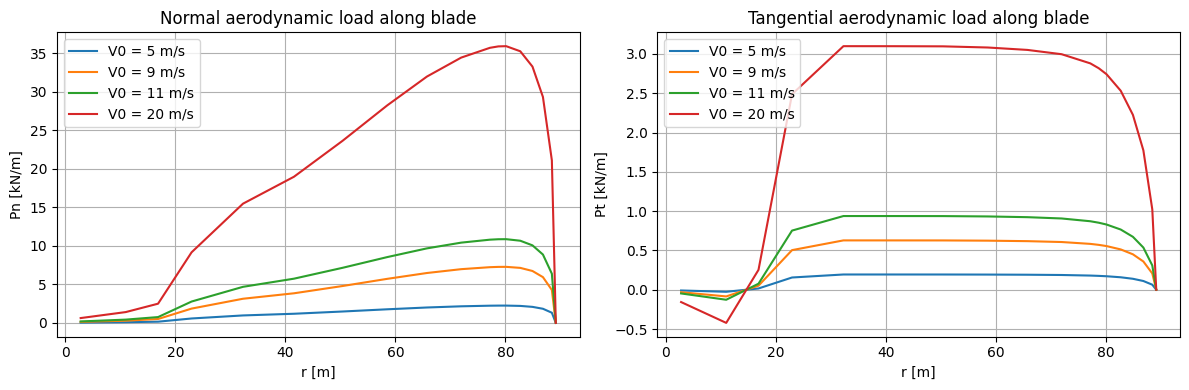

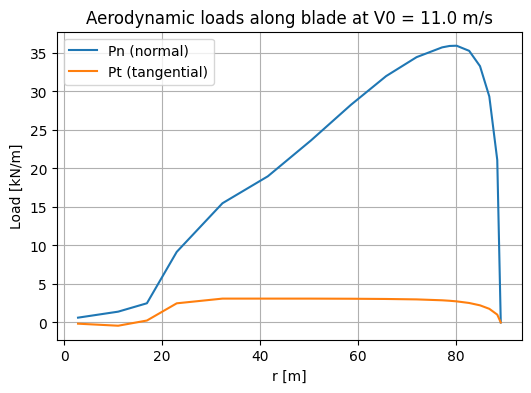

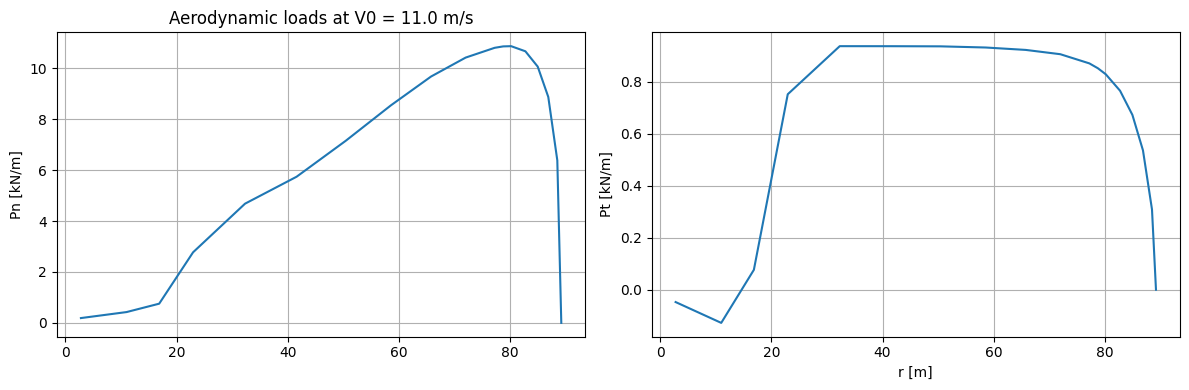

In [6]:
# ======================================================
#  Q4 – Aerodynamic loads along the blade for Vo = 5, 9, 11, 20 m/s
#      Using the "long" BEM code & optimal (lambda_opt, theta_opt)
# ======================================================

def compute_spanwise_loads(V0, lam, theta_p_deg,
                           R, Blades,
                           blade_data, radius,
                           aoa, lift_coefficient, drag_coefficients,
                           thickness_to_chord, rho):
    """
    Solve BEM along the radius for a *single operating point*:
       - free-stream wind speed V0 [m/s]
       - tip-speed ratio lam = ΩR / V0
       - pitch angle at the blade theta_p_deg [deg] (uniform)

    Returns
    -------
    radius : 1D array           (same as input radius)
    Pt_elem : 1D array [N/m]    tangential load per unit span (one blade)
    Pn_elem : 1D array [N/m]    normal load per unit span (one blade)
    """

    Omega   = lam * V0 / R
    theta_p = np.deg2rad(theta_p_deg)

    nsec = blade_data.shape[0]
    Pt_elem = np.zeros(nsec)
    Pn_elem = np.zeros(nsec)

    for e in range(nsec - 1):
        r        = radius[e]
        chord    = blade_data[e, 1]
        twist    = np.deg2rad(blade_data[e, 2])
        t_over_c = blade_data[e, 3]

        # Initial guesses for a and a'
        a, a_new   = 0.35, 0.10
        ap, ap_new = 0.0, 0.10
        f_relax    = 0.10
        tol_res    = 1e-6
        it, itmax  = 0, 1000

        # --------- BEM iteration at this element ----------
        while True:
            it += 1
            a, ap = a_new, ap_new

            # Velocity triangle and AoA
            phi       = flow_angle(V0, a, ap, Omega, r)
            alpha_deg = angle_of_attack(phi, twist, theta_p)

            # Cl(α, t/c) and Cd(α, t/c)
            Cl, Cd = interpolate_airfoil(
                alpha_deg, t_over_c,
                aoa, lift_coefficient, drag_coefficients,
                thickness_to_chord
            )

            # Cn and Ct
            Cn, Ct = force_coefficients(Cl, Cd, phi)

            # Solidity and tip-loss
            sigma = solidity(Blades, chord, r)
            F     = prandtl_tip_loss(Blades, R, r, phi)

            # Update a and a'
            a_new, ap_new = update_a_ap(
                a, ap, Cn, Ct, sigma, phi, F,
                f_relax=f_relax,
                use_madsen=False
            )

            # Convergence check
            res_n = a_new - a
            res_t = ap_new - ap
            if max(abs(res_n), abs(res_t)) < tol_res or it >= itmax:
                a, ap = a_new, ap_new
                break

        # --------- Loads with converged a, a' ----------
        phi       = flow_angle(V0, a, ap, Omega, r)
        alpha_deg = angle_of_attack(phi, twist, theta_p)

        Cl, Cd = interpolate_airfoil(
            alpha_deg, t_over_c,
            aoa, lift_coefficient, drag_coefficients,
            thickness_to_chord
        )

        Vrel = relative_velocity(V0, a, ap, Omega, r)
        Pt_elem[e], Pn_elem[e] = section_loads(
            rho, Vrel, chord, Cl, Cd, phi
        )

    return radius, Pt_elem, Pn_elem


# -------------------------
# Compute and plot for V0 = 5, 9, 11, 20 m/s
# -------------------------
V_list = [5.0, 9.0, 11.0, 20.0]

# Usamos lambda_opt y theta_opt que ya habíamos calculado con compute_complete_BEM
lam_oper   = lambda_opt
theta_oper = theta_opt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for V0_plot in V_list:
    r_vec, Pt_vec, Pn_vec = compute_spanwise_loads(
        V0_plot, lam_oper, theta_oper,
        R, Blades,
        blade_data, radius,
        aoa, lift_coefficient, drag_coefficients,
        thickness_to_chord, rho
    )

    # Normal load (per blade) in kN/m
    axs[0].plot(r_vec, Pn_vec / 1e3, label=f"V0 = {V0_plot:.0f} m/s")

    # Tangential load (per blade) in kN/m
    axs[1].plot(r_vec, Pt_vec / 1e3, label=f"V0 = {V0_plot:.0f} m/s")

axs[0].set_xlabel("r [m]")
axs[0].set_ylabel("Pn [kN/m]")
axs[0].set_title("Normal aerodynamic load along blade")
axs[0].grid(True)
axs[0].legend()

axs[1].set_xlabel("r [m]")
axs[1].set_ylabel("Pt [kN/m]")
axs[1].set_title("Tangential aerodynamic load along blade")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()



# ==========================================
#  Extra: loads only for V0 = 11 m/s
# ==========================================
# Este sería el caso que solo queramos plotear las cargas para una velocidad

V0_single = 11.0   # aquí cambias la velocidad que quieras

r_11, Pt_11, Pn_11 = compute_spanwise_loads(
    V0_single, lam_oper, theta_oper,
    R, Blades,
    blade_data, radius,
    aoa, lift_coefficient, drag_coefficients,
    thickness_to_chord, rho
)

plt.figure(figsize=(6,4))
plt.plot(r_11, Pn_vec / 1e3, label="Pn (normal)")
plt.plot(r_11, Pt_vec / 1e3, label="Pt (tangential)")
plt.xlabel("r [m]")
plt.ylabel("Load [kN/m]")
plt.title(f"Aerodynamic loads along blade at V0 = {V0_single:.1f} m/s")
plt.grid(True)
plt.legend()
plt.show()


# Por tener dos opciones, si lo quieres en un mismo gráfico o en dos distintos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax1.plot(r_11, Pn_11 / 1e3)
ax1.set_ylabel("Pn [kN/m]")
ax1.set_title(f"Aerodynamic loads at V0 = {V0_single:.1f} m/s")
ax1.grid(True)

ax2.plot(r_11, Pt_11 / 1e3)
ax2.set_xlabel("r [m]")
ax2.set_ylabel("Pt [kN/m]")
ax2.grid(True)

plt.tight_layout()
plt.show()





--- Task 5: Annual Energy Production (ideal power curve) ---
AEP (cut-out 25 m/s) = 38354.27 MWh/year
AEP (cut-out 20 m/s) = 37465.92 MWh/year
Energy lost (20 vs 25) = 888.35 MWh/year
Relative loss = 2.316 % of annual energy



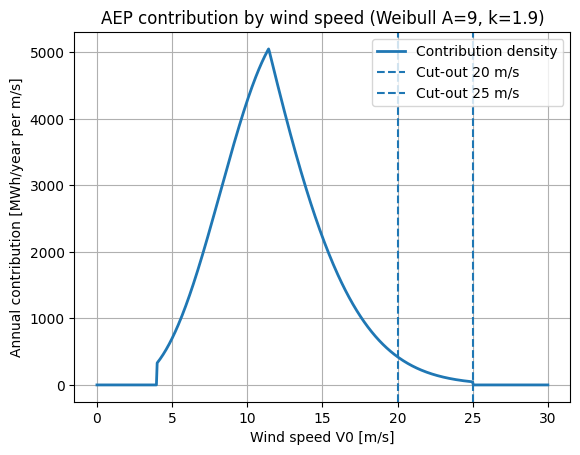

Check: integral[20,25] = 887.96 MWh/year (vs loss = 888.35)


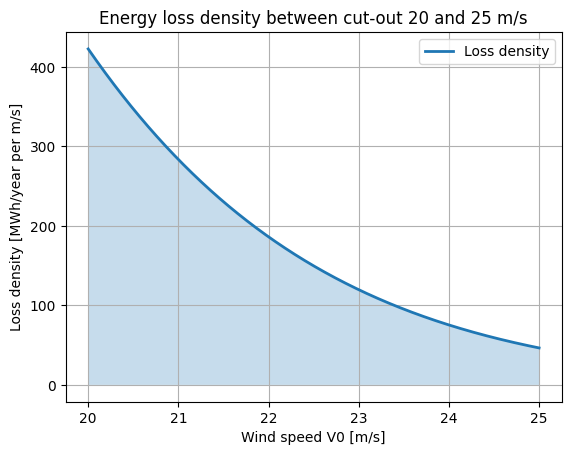

In [7]:
# ======================================================
# Task 5: Annual Energy Production (AEP) - sin feather/stall
# Curva de potencia ideal:
#   - 0          si V < V_in o V > V_cut_out
#   - Cp_max*V^3 si V_in <= V <= V_rated
#   - P_rated    si V_rated < V <= V_cut_out
# ======================================================

import numpy as np
import matplotlib.pyplot as plt

# Weibull parameters given in the assignment
A_weibull = 9.0   # [m/s]
k_weibull = 1.9   # [-]
HOURS_PER_YEAR = 8760  # [h/year]

# Rated power from the assignment / previous tasks
P_rated_W = 10.64e6  # [W]

# Rotor swept area
A_rotor = np.pi * R**2

def weibull_pdf(v, A, k):
    """
    Weibull probability density function:
        f(V) = (k/A) * (V/A)^(k-1) * exp( - (V/A)^k )

    - v: wind speed [m/s]
    - A: scale parameter [m/s]
    - k: shape parameter [-]
    """
    v = np.asarray(v)
    v_over_A = np.where(A > 0.0, v / A, 0.0)
    return (k / A) * np.power(v_over_A, k - 1) * np.exp(-np.power(v_over_A, k))


def power_curve_ideal(V, V_cut_out):
    """
    Idealized power curve P(V) [W] for a pitch-regulated turbine:

        P = 0                                  V < V_in or V > V_cut_out
        P = 0.5 * rho * A_rotor * Cp_max * V^3 V_in <= V <= V_rated
        P = P_rated_W                          V_rated <  V <= V_cut_out

    Usa:
      - cp_max      (máximo Cp de tu mapa BEM)
      - V_rated     (calculado en tu sección anterior)
      - V_in        (cut-in)
      - V_cut_out   (parámetro de la función)
    """
    V = np.asarray(V)
    P = np.zeros_like(V, dtype=float)

    # Zona óptima: Cp_max * V^3
    mask_below_rated = (V >= V_in) & (V <= V_rated)
    P[mask_below_rated] = 0.5 * rho * A_rotor * cp_max * V[mask_below_rated]**3

    # Zona a potencia nominal: P_rated
    mask_rated = (V > V_rated) & (V <= V_cut_out)
    P[mask_rated] = P_rated_W

    # Fuera de [V_in, V_cut_out] ya hemos dejado P = 0
    return P


def compute_AEP_ideal(V_cut_out, A_weibull, k_weibull):
    """
    Compute AEP [MWh/year] for the idealized power curve and a given cut-out.

    AEP = 8760 * ∫_0^{V_cut_out} P(V) f(V) dV / 1e6
    """
    V_eval = np.linspace(0.0, V_cut_out, 2000)
    P_eval = power_curve_ideal(V_eval, V_cut_out)   # [W]
    f_eval = weibull_pdf(V_eval, A_weibull, k_weibull)  # [1/(m/s)]

    integrand = P_eval * f_eval                     # [W/(m/s)]
    expected_power_W = np.trapezoid(integrand, V_eval)  # [W]

    AEP_MWh = HOURS_PER_YEAR * expected_power_W / 1e6
    return AEP_MWh


# --- AEP con cut-out 25 m/s y 20 m/s ---
AEP_25 = compute_AEP_ideal(25.0, A_weibull, k_weibull)
AEP_20 = compute_AEP_ideal(20.0, A_weibull, k_weibull)
loss   = AEP_25 - AEP_20

print("\n--- Task 5: Annual Energy Production (ideal power curve) ---")
print(f"AEP (cut-out 25 m/s) = {AEP_25:.2f} MWh/year")
print(f"AEP (cut-out 20 m/s) = {AEP_20:.2f} MWh/year")
print(f"Energy lost (20 vs 25) = {loss:.2f} MWh/year")

loss_percent = 100.0 * loss / AEP_25
print(f"Relative loss = {loss_percent:.3f} % of annual energy\n")


# ------------------------------------------------------
# Visualización: contribución a la AEP por velocidad
# ------------------------------------------------------
V_plot = np.linspace(0.0, 30.0, 600)
P_plot_25 = power_curve_ideal(V_plot, 25.0)
f_plot    = weibull_pdf(V_plot, A_weibull, k_weibull)

# dAEP/dV = 8760 * P(V) * f(V) / 1e6  [MWh/año por m/s]
contribution = HOURS_PER_YEAR * P_plot_25 * f_plot / 1e6

plt.figure()
plt.plot(V_plot, contribution, linewidth=2, label="Contribution density")
plt.axvline(20, linestyle="--", label="Cut-out 20 m/s")
plt.axvline(25, linestyle="--", label="Cut-out 25 m/s")
plt.xlabel("Wind speed V0 [m/s]")
plt.ylabel("Annual contribution [MWh/year per m/s]")
plt.title("AEP contribution by wind speed (Weibull A=9, k=1.9)")
plt.grid(True)
plt.legend()
plt.show()


# ------------------------------------------------------
# Densidad de pérdida entre 20 y 25 m/s
# ------------------------------------------------------
V_loss = np.linspace(20.0, 25.0, 1000)
P_loss = power_curve_ideal(V_loss, 25.0)  # power curve con cut-out 25
f_loss = weibull_pdf(V_loss, A_weibull, k_weibull)

loss_density = HOURS_PER_YEAR * P_loss * f_loss / 1e6  # [MWh/año por m/s]
loss_from_density = np.trapezoid(loss_density, V_loss)

print(f"Check: integral[20,25] = {loss_from_density:.2f} MWh/year "
      f"(vs loss = {loss:.2f})")

plt.figure()
plt.plot(V_loss, loss_density, lw=2, label="Loss density")
plt.fill_between(V_loss, 0.0, loss_density, alpha=0.25)
plt.xlabel("Wind speed V0 [m/s]")
plt.ylabel("Loss density [MWh/year per m/s]")
plt.title("Energy loss density between cut-out 20 and 25 m/s")
plt.grid(True)
plt.legend()
plt.show()

Tip deflection tangential (edgewise) dy_tip =  3.105 m
Tip deflection normal (flapwise)   dz_tip = 32.010 m
Root radius used                 r_root =  2.80 m
Root bending moment My(root)  = -9.842e+07 Nm
Root bending moment Mz(root)  =  1.003e+07 Nm
Tip radius used               r_tip  = 89.17 m
Tip bending moment My(tip)  =  0.000e+00 Nm
Tip bending moment Mz(tip)  =  0.000e+00 Nm


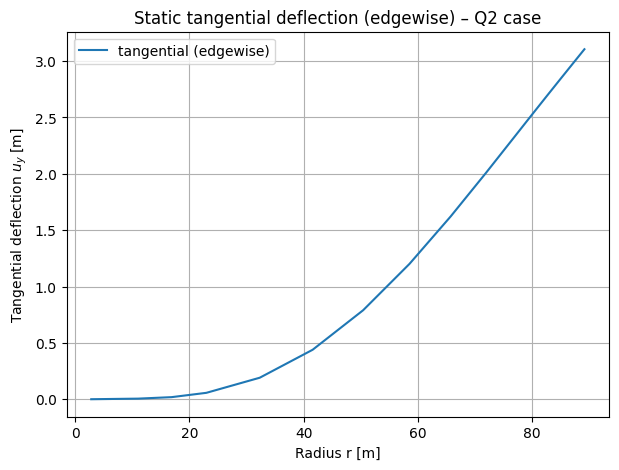

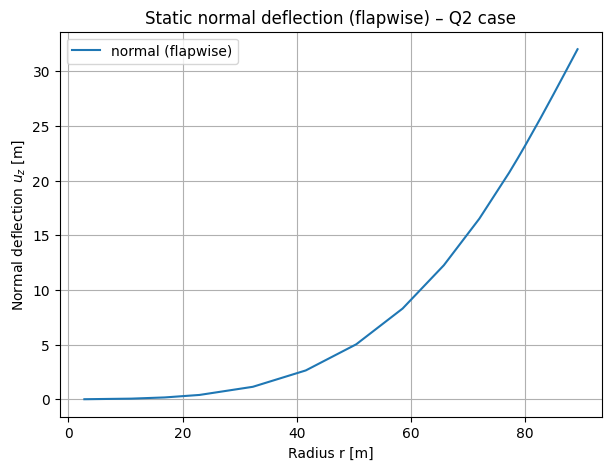

In [8]:
# ======================================================
# STATIC DEFLACTIONS PARA UNA V0
# ======================================================
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

def compute_static_deflection(radius,
                              Pn, Pt,  # [N/m] normal & tangential loads
                              struct_pitch_deg,
                              EI1, EI2,  # [Nm^2] principal bending stiffness
                              twist_deg):
    """
    radius : array [m]        (r_1 ... r_N, from root to tip)
    pn     : array [N/m]      distributed load normal to rotor plane
    pt     : array [N/m]      distributed load tangential to rotor plane
    struct_pitch_deg : array [deg] structural pitch
    EI1, EI2          : arrays [Nm^2] bending stiffness about principal axes 1 & 2
    twist_deg         : array [deg] geometric twist

    Returns:
        dy : tangential deflection (in-plane)  [m]
        dz : normal deflection (out-of-plane)  [m]
        My, Mz : bending moments at each radius [Nm]
    """

    r = np.asarray(radius)
    N = len(r)

    # rotor-plane loads -> y,z components
    py = np.asarray(Pt)   # tangential (edgewise)
    pz = np.asarray(Pn)   # normal (flapwise)

    # STEP 1: INTERNAL FORCES (integrate from tip to root)
    Ty = np.zeros(N)
    Tz = np.zeros(N)
    My = np.zeros(N)
    Mz = np.zeros(N)

    # Tip BC: Ty[N-1]=Tz[N-1]=My[N-1]=Mz[N-1]=0 ya están con zeros
    for i in range(N - 1, 0, -1):   # i = N-1 ... 1
        dx = r[i] - r[i-1]

        Ty[i-1] = Ty[i] + 0.5 * (py[i] + py[i-1]) * dx
        Tz[i-1] = Tz[i] + 0.5 * (pz[i] + pz[i-1]) * dx

        My[i-1] = (My[i] - Tz[i] * dx
                   - ((1.0/6.0) * pz[i-1] + (1.0/3.0) * pz[i]) * dx**2)
        Mz[i-1] = (Mz[i] + Ty[i] * dx
                   + ((1.0/6.0) * py[i-1] + (1.0/3.0) * py[i]) * dx**2)

    # STEP 2: MOMENTOS -> CURVATURAS (vigas con ejes principales 1–2)
    struct_pitch = np.deg2rad(struct_pitch_deg)  # θ_p
    twist        = np.deg2rad(twist_deg)         # β
    alpha        = struct_pitch + twist          # orientación ejes principales

    EI1 = np.asarray(EI1)
    EI2 = np.asarray(EI2)

    # transformar My,Mz -> M1,M2
    M1 = My * np.cos(alpha) - Mz * np.sin(alpha)
    M2 = My * np.sin(alpha) + Mz * np.cos(alpha)

    kappa1 = M1 / EI1
    kappa2 = M2 / EI2

    # volver a κ_y, κ_z
    kappa_y = kappa1 * np.cos(alpha) + kappa2 * np.sin(alpha)
    kappa_z = -kappa1 * np.sin(alpha) + kappa2 * np.cos(alpha)

    # STEP 3: CURVATURA -> ÁNGULOS Y DEFLEXIONES (integrar de raíz a punta)
    thetay = np.zeros(N)
    thetaz = np.zeros(N)
    dy = np.zeros(N)
    dz = np.zeros(N)

    # raíz empotrada: dy[0]=dz[0]=thetay[0]=thetaz[0]=0
    for i in range(0, N - 1):       # i = 0 ... N-2
        dx = r[i+1] - r[i]

        thetay[i+1] = thetay[i] + 0.5 * (kappa_y[i+1] + kappa_y[i]) * dx
        thetaz[i+1] = thetaz[i] + 0.5 * (kappa_z[i+1] + kappa_z[i]) * dx

        dy[i+1] = (dy[i] + thetaz[i] * dx
                   + ((1.0/6.0) * kappa_z[i+1] + (1.0/3.0) * kappa_z[i]) * dx**2)
        dz[i+1] = (dz[i] - thetay[i] * dx
                   - ((1.0/6.0) * kappa_y[i+1] + (1.0/3.0) * kappa_y[i]) * dx**2)

    return dy, dz, My, Mz


# 1) Cargar datos estructurales
bladestruc = np.loadtxt("bladestruc.txt")

radius_struct    = bladestruc[:, 0]
struct_pitch_deg = bladestruc[:, 1]
EI1              = bladestruc[:, 3]
EI2              = bladestruc[:, 4]
twist_deg        = bladestruc[:, 5]

# 2) Interpolar cargas aerodinámicas BEM (Pn,Pt) a la malla estructural
#    Pn (normal), Pt (tangencial)
Pn = np.interp(radius_struct, r_11, Pn_vec)   # [N/m] AQUI ES DONDE VARIA QUE SEA SOLO PARA UNA V0 PORQUE SOLO COGEMOS LAS CARGAS EN R11
Pt = np.interp(radius_struct, r_11, Pt_vec)   # [N/m]

# 3) Calcular deflexiones y momentos con la rutina estructural

dy, dz, My, Mz= compute_static_deflection(radius_struct, Pn, Pt, struct_pitch_deg,EI1, EI2, twist_deg)

# 4) Momentos en la raíz (r = 2.8 m)
r_root = 2.8
idx_root = int(np.argmin(np.abs(radius_struct - r_root)))

M_root_y = My[idx_root]   # momento respecto a eje y
M_root_z = Mz[idx_root]   # momento respecto a eje z

# 4) Momentos en la tip (r = 89,2 m)
r_tip = 89.17   # último nodo de radio (la tip)
idx_tip = int(np.argmin(np.abs(radius_struct - r_tip)))

M_tip_y = My[idx_tip]   # momento respecto a eje y en la tip
M_tip_z = Mz[idx_tip]   # momento respecto a eje z en la tip


print(f"Tip deflection tangential (edgewise) dy_tip = {dy[-1]:6.3f} m")
print(f"Tip deflection normal (flapwise)   dz_tip = {dz[-1]:6.3f} m")
print(f"Root radius used                 r_root = {radius_struct[idx_root]:5.2f} m")
print(f"Root bending moment My(root)  = {M_root_y:10.3e} Nm")
print(f"Root bending moment Mz(root)  = {M_root_z:10.3e} Nm")
print(f"Tip radius used               r_tip  = {r_tip:5.2f} m")
print(f"Tip bending moment My(tip)  = {M_tip_y:10.3e} Nm")
print(f"Tip bending moment Mz(tip)  = {M_tip_z:10.3e} Nm")

# 5) Plots de deflexión vs radio (solo para este caso Q2)
plt.figure(figsize=(7, 5))
plt.plot(radius_struct, dy, label="tangential (edgewise)")
plt.xlabel("Radius r [m]")
plt.ylabel("Tangential deflection $u_y$ [m]")
plt.title("Static tangential deflection (edgewise) – Q2 case")
plt.grid(True)
plt.legend()

plt.figure(figsize=(7, 5))
plt.plot(radius_struct, dz, label="normal (flapwise)")
plt.xlabel("Radius r [m]")
plt.ylabel("Normal deflection $u_z$ [m]")
plt.title("Static normal deflection (flapwise) – Q2 case")
plt.grid(True)
plt.legend()

plt.show()


V0 = 6 m/s:
  tip dy =  0.281 m, dz =  3.151 m
V0 = 11 m/s:
  tip dy =  0.918 m, dz =  9.054 m
V0 = 20 m/s:
  tip dy =  0.353 m, dz =  1.965 m


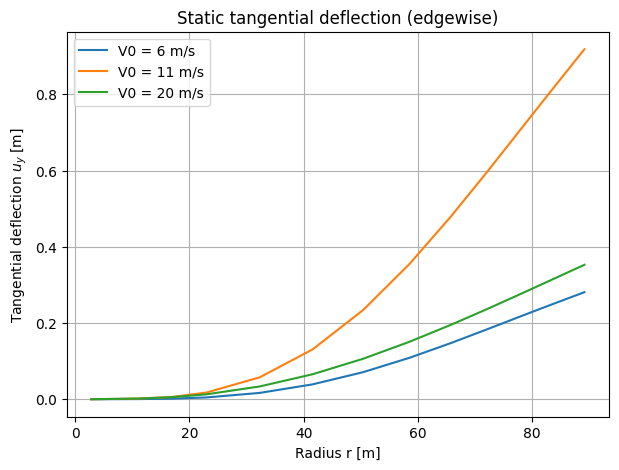

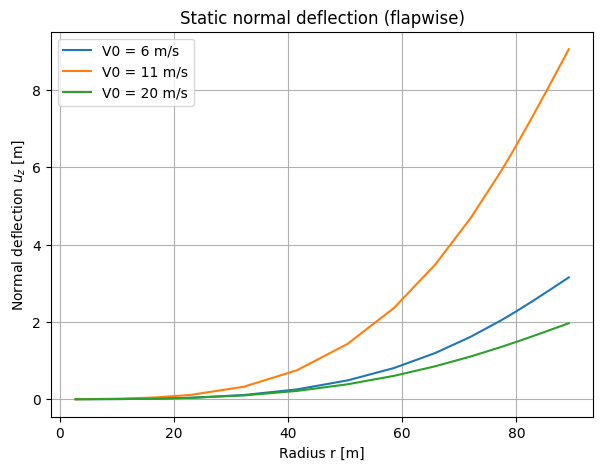

In [9]:
# ======================================================
# STATIC DEFLACTIONS PARA DIFERENTES V0 CON ARRAYS
# ======================================================
def compute_static_deflection(radius,
                              Pn, Pt,  # [N/m] normal & tangential loads
                              struct_pitch_deg,
                              EI1, EI2,  # [Nm^2] principal bending stiffness
                              twist_deg):
    """
    radius : array [m]        (r_1 ... r_N, from root to tip)
    pn     : array [N/m]      distributed load normal to rotor plane
    pt     : array [N/m]      distributed load tangential to rotor plane
    struct_pitch_deg : array [deg] structural pitch
    EI1, EI2          : arrays [Nm^2] bending stiffness about principal axes 1 & 2
    twist_deg         : array [deg] geometric twist

    Returns:
        dy : tangential deflection (in-plane)  [m]
        dz : normal deflection (out-of-plane)  [m]
    """

    r = np.asarray(radius)
    N = len(r)

    ### STEP 0 ###
    # map rotor-plane loads to y,z components (slides: p_y, p_z)
    # y = tangential (edgewise), z = normal (flapwise)
    py = np.asarray(Pt)   # tangential
    pz = np.asarray(Pn)   # normal

    ### STEP 1: INTERNAL FORCES ###
    # internal shear forces T_y, T_z and moments M_y, M_z
    # Tip boundary conditions: T_y(N) = T_z(N) = M_y(N) = M_z(N) = 0
    # Integrate from tip (i=N-1) towards root (i=0).
    # (Formulas from slide "So summing up", i = N..2)

    Ty = np.zeros(N)
    Tz = np.zeros(N)
    My = np.zeros(N)
    Mz = np.zeros(N)


    for i in range(N - 1, 0, -1):         # i = N-1 ... 1 (pos 2 = 1 because python starts the arrays in 0)
        dx = r[i] - r[i-1]

        Ty[i-1] = Ty[i] + 0.5 * (py[i] + py[i-1]) * dx
        Tz[i-1] = Tz[i] + 0.5 * (pz[i] + pz[i-1]) * dx

        My[i-1] = (My[i] - Tz[i] * dx - ((1.0/6.0) * pz[i-1] + (1.0/3.0) * pz[i]) * dx**2)
        Mz[i-1] = (Mz[i] + Ty[i] * dx + ((1.0/6.0) * py[i-1] + (1.0/3.0) * py[i]) * dx**2)

    ### STEP 2: CURVATURE ###
    # moments -> curvatures via principal axes
    # (slides: M1,M2 from My,Mz using angle β+θ_p, with v≈0;
    #          κ1 = M1/EI1, κ2 = M2/EI2; then back to κ_y, κ_z)

    struct_pitch = np.deg2rad(struct_pitch_deg) # Pitch angle (θ_p)
    twist = np.deg2rad(twist_deg)               # Twist angle (β)
    alpha = struct_pitch + twist                # effective angle of principal axes

    # EI: overall resistance of the beam to bending [Nm^2]
    EI1 = np.asarray(EI1)                       # E: Young’s modulus (elasticity of material) [Pa]
    EI2 = np.asarray(EI2)                       # Moment of inertia (stiffness of beam shape) [m^4]

    # M: bending moments [Nm] o [kg·m/s^2]
    # 1: Flapwise curvature
    # 2: Edgewise curvature
    M1 = My * np.cos(alpha) - Mz * np.sin(alpha)
    M2 = My * np.sin(alpha) + Mz * np.cos(alpha)

    # Curvatures [m^(-1)]
    kappa1 = M1 / EI1
    kappa2 = M2 / EI2

    kappa_y = kappa1 * np.cos(alpha) + kappa2 * np.sin(alpha)
    kappa_z = -kappa1 * np.sin(alpha) + kappa2 * np.cos(alpha)


    ### Step 3: ANGLE AND DEFECTION ###
    # curvature -> rotations θ_y, θ_z and deflections u_y, u_z
    # Clamped root: u_y(0)=u_z(0)=θ_y(0)=θ_z(0)=0
    # Integrate from root to tip (slides: i = 1..N-1).

    thetay = np.zeros(N)
    thetaz = np.zeros(N)
    dy = np.zeros(N)   # tangential deflection
    dz = np.zeros(N)   # normal deflection

##¿¿¿¿¿¿PREGUNTAR JUEVES N-1/N-2?????

    for i in range(0, N - 1):            # i = 0 ... N-2
        dx = r[i+1] - r[i]

        thetay[i+1] = (thetay[i] + 0.5 * (kappa_y[i+1] + kappa_y[i]) * dx)
        thetaz[i+1] = (thetaz[i] + 0.5 * (kappa_z[i+1] + kappa_z[i]) * dx)

        dy[i+1] = (dy[i] + thetaz[i] * dx + ((1.0/6.0) * kappa_z[i+1] + (1.0/3.0) * kappa_z[i]) * dx**2)
        dz[i+1] = (dz[i] - thetay[i] * dx - ((1.0/6.0) * kappa_y[i+1] + (1.0/3.0) * kappa_y[i]) * dx**2)

    return dy, dz, My, Mz

# (*) We neglect the tip values because the loads there are 0, so if we compute with this code it will be 0 (not real)



# 1) Cargar datos estructurales
bladestruc = np.loadtxt("bladestruc.txt")

radius_struct    = bladestruc[:, 0]
struct_pitch_deg = bladestruc[:, 1]
EI1              = bladestruc[:, 3]
EI2              = bladestruc[:, 4]
twist_deg        = bladestruc[:, 5]


# 2) Cargar los archivos de las cargas en las diferentes velocidades que nos da el enunciado
load_files = {
    6:  "loads6.txt",
    11: "loads11.txt",
    20: "loads20.txt",
}

deflections_tan = {}
deflections_norm = {}

# 3) Leer los archivos de las cargas y adjudicar a cada columna su variable para leerlo
for V0, fname in load_files.items():
    data = np.loadtxt(fname)

    radius_load = data[:, 0]
    Pn = data[:, 1]   # [N/m] normal to rotor plane
    Pt = data[:, 2]   # [N/m] tangential to rotor plane

    # OPCIONAL: Make sure structural and load radii match (otherwise interpolate)
    if not np.allclose(radius_load, radius_struct, atol=1e-3):
        raise ValueError("Radius in loads and bladestruc do not match.")

    dy, dz, My, Mz = compute_static_deflection(radius_struct,Pn, Pt,struct_pitch_deg,EI1, EI2,twist_deg)

    deflections_tan[V0]  = dy
    deflections_norm[V0] = dz

    print(f"V0 = {V0} m/s:")
    print(f"  tip dy = {dy[-1]:6.3f} m, dz = {dz[-1]:6.3f} m")

# 4) Plots: deflection vs radius (tangential & normal)

plt.figure(figsize=(7, 5))
for V0 in sorted(load_files.keys()):
    plt.plot(radius_struct, deflections_tan[V0],label=f"V0 = {V0} m/s")
plt.xlabel("Radius r [m]")
plt.ylabel("Tangential deflection $u_y$ [m]")
plt.title("Static tangential deflection (edgewise)")
plt.grid(True)
plt.legend()

plt.figure(figsize=(7, 5))
for V0 in sorted(load_files.keys()):
    plt.plot(radius_struct, deflections_norm[V0],label=f"V0 = {V0} m/s")
plt.xlabel("Radius r [m]")
plt.ylabel("Normal deflection $u_z$ [m]")
plt.title("Static normal deflection (flapwise)")
plt.grid(True)
plt.legend()

plt.show()


In [10]:
# ======================================================
# STATIC DEFLACTIONS PARA DIFERENTES V0 SIN ARRAYS
# ======================================================

##PRIMERO HAY QUE COPIAR TODO LO DEL BEM SINO NO DARÁ NADA

def compute_static_deflection(radius,
                              Pn, Pt,  # [N/m] normal & tangential loads
                              struct_pitch_deg,
                              EI1, EI2,  # [Nm^2] principal bending stiffness
                              twist_deg):
    """
    radius : array [m]        (r_1 ... r_N, from root to tip)
    pn     : array [N/m]      distributed load normal to rotor plane
    pt     : array [N/m]      distributed load tangential to rotor plane
    struct_pitch_deg : array [deg] structural pitch
    EI1, EI2          : arrays [Nm^2] bending stiffness about principal axes 1 & 2
    twist_deg         : array [deg] geometric twist

    Returns:
        dy : tangential deflection (in-plane)  [m]
        dz : normal deflection (out-of-plane)  [m]
    """

    r = np.asarray(radius)
    N = len(r)

    ### STEP 0 ###
    # map rotor-plane loads to y,z components (slides: p_y, p_z)
    # y = tangential (edgewise), z = normal (flapwise)
    py = np.asarray(Pt)   # tangential
    pz = np.asarray(Pn)   # normal

    ### STEP 1: INTERNAL FORCES ###
    # internal shear forces T_y, T_z and moments M_y, M_z
    # Tip boundary conditions: T_y(N) = T_z(N) = M_y(N) = M_z(N) = 0
    # Integrate from tip (i=N-1) towards root (i=0).
    # (Formulas from slide "So summing up", i = N..2)

    Ty = np.zeros(N)
    Tz = np.zeros(N)
    My = np.zeros(N)
    Mz = np.zeros(N)


    for i in range(N - 1, 0, -1):         # i = N-1 ... 1 (pos 2 = 1 because python starts the arrays in 0)
        dx = r[i] - r[i-1]

        Ty[i-1] = Ty[i] + 0.5 * (py[i] + py[i-1]) * dx
        Tz[i-1] = Tz[i] + 0.5 * (pz[i] + pz[i-1]) * dx

        My[i-1] = (My[i] - Tz[i] * dx - ((1.0/6.0) * pz[i-1] + (1.0/3.0) * pz[i]) * dx**2)
        Mz[i-1] = (Mz[i] + Ty[i] * dx + ((1.0/6.0) * py[i-1] + (1.0/3.0) * py[i]) * dx**2)

    ### STEP 2: CURVATURE ###
    # moments -> curvatures via principal axes
    # (slides: M1,M2 from My,Mz using angle β+θ_p, with v≈0;
    #          κ1 = M1/EI1, κ2 = M2/EI2; then back to κ_y, κ_z)

    struct_pitch = np.deg2rad(struct_pitch_deg) # Pitch angle (θ_p)
    twist = np.deg2rad(twist_deg)               # Twist angle (β)
    alpha = struct_pitch + twist                # effective angle of principal axes

    # EI: overall resistance of the beam to bending [Nm^2]
    EI1 = np.asarray(EI1)                       # E: Young’s modulus (elasticity of material) [Pa]
    EI2 = np.asarray(EI2)                       # Moment of inertia (stiffness of beam shape) [m^4]

    # M: bending moments [Nm] o [kg·m/s^2]
    # 1: Flapwise curvature
    # 2: Edgewise curvature
    M1 = My * np.cos(alpha) - Mz * np.sin(alpha)
    M2 = My * np.sin(alpha) + Mz * np.cos(alpha)

    # Curvatures [m^(-1)]
    kappa1 = M1 / EI1
    kappa2 = M2 / EI2

    kappa_y = kappa1 * np.cos(alpha) + kappa2 * np.sin(alpha)
    kappa_z = -kappa1 * np.sin(alpha) + kappa2 * np.cos(alpha)


    ### Step 3: ANGLE AND DEFECTION ###
    # curvature -> rotations θ_y, θ_z and deflections u_y, u_z
    # Clamped root: u_y(0)=u_z(0)=θ_y(0)=θ_z(0)=0
    # Integrate from root to tip (slides: i = 1..N-1).

    thetay = np.zeros(N)
    thetaz = np.zeros(N)
    dy = np.zeros(N)   # tangential deflection
    dz = np.zeros(N)   # normal deflection

##¿¿¿¿¿¿PREGUNTAR JUEVES N-1/N-2?????

    for i in range(0, N - 1):            # i = 0 ... N-2
        dx = r[i+1] - r[i]

        thetay[i+1] = (thetay[i] + 0.5 * (kappa_y[i+1] + kappa_y[i]) * dx)
        thetaz[i+1] = (thetaz[i] + 0.5 * (kappa_z[i+1] + kappa_z[i]) * dx)

        dy[i+1] = (dy[i] + thetaz[i] * dx + ((1.0/6.0) * kappa_z[i+1] + (1.0/3.0) * kappa_z[i]) * dx**2)
        dz[i+1] = (dz[i] - thetay[i] * dx - ((1.0/6.0) * kappa_y[i+1] + (1.0/3.0) * kappa_y[i]) * dx**2)

    return dy, dz, My, Mz

# (*) We neglect the tip values because the loads there are 0, so if we compute with this code it will be 0 (not real)



# 1) Cargar datos estructurales
bladestruc = np.loadtxt("bladestruc.txt")

radius_struct    = bladestruc[:, 0]
struct_pitch_deg = bladestruc[:, 1]
EI1              = bladestruc[:, 3]
EI2              = bladestruc[:, 4]
twist_deg        = bladestruc[:, 5]


V0_list = [6, 11, 14, 20]   # o el rango que quieras

deflections_tan = {}
deflections_norm = {}

for V0 in V0_list:
    # 1) para esta V0 defines Omega / lambda / pitch que toque
    lam   = Omega * R / V0      # o el λ que quieras estudiar
    theta = pitch_angle         # por ejemplo

    # 2) corres BEM para obtener Ft(r) y Fn(r) en la malla aerodinámica `radius`
    r_BEM, Ft_vec, Fn_vec = compute_spanwise_loads(V0, lam, theta,
                                                   R, Blades,
                                                   blade_data, radius,
                                                   aoa, lift_coefficient, drag_coefficients,
                                                   thickness_to_chord, rho)

    # 3) mapear a la malla estructural: Pn = Fn, Pt = Ft
    Pn = np.interp(radius_struct, r_BEM, Fn_vec)   # [N/m]
    Pt = np.interp(radius_struct, r_BEM, Ft_vec)   # [N/m]

    # 4) deflexiones y momentos para esa V0
    dy, dz, My, Mz = compute_static_deflection(radius_struct,
                                               Pn, Pt,
                                               struct_pitch_deg,
                                               EI1, EI2,
                                               twist_deg)

    deflections_tan[V0]  = dy
    deflections_norm[V0] = dz

    print(f"V0 = {V0} m/s:")
    print(f"  tip dy = {dy[-1]:6.3f} m, dz = {dz[-1]:6.3f} m")

# 4) Plots: deflection vs radius (tangential & normal)

plt.figure(figsize=(7, 5))
for V0 in sorted(load_files.keys()):
    plt.plot(radius_struct, deflections_tan[V0],label=f"V0 = {V0} m/s")
plt.xlabel("Radius r [m]")
plt.ylabel("Tangential deflection $u_y$ [m]")
plt.title("Static tangential deflection (edgewise)")
plt.grid(True)
plt.legend()

plt.figure(figsize=(7, 5))
for V0 in sorted(load_files.keys()):
    plt.plot(radius_struct, deflections_norm[V0],label=f"V0 = {V0} m/s")
plt.xlabel("Radius r [m]")
plt.ylabel("Normal deflection $u_z$ [m]")
plt.title("Static normal deflection (flapwise)")
plt.grid(True)
plt.legend()

plt.show()


NameError: name 'Omega' is not defined